BAKER HUGHES CHALLENGE

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.spatial import cKDTree
from scipy.stats import pearsonr
from sklearn.neighbors import NearestNeighbors


Data Loading and Exploratory Analysis

In [2]:
#Load Dataset
df1  = pd.read_csv("data_set_1.csv", header=None)
df1.columns = ['ID', 'FREQ', 'POWER']
df1.head()

,ID,FREQ,POWER
0,1,0.719791,0.317260
1,2,0.718572,0.308538
2,3,0.717821,0.303025
3,4,0.725701,0.363205
4,5,0.724039,0.350726


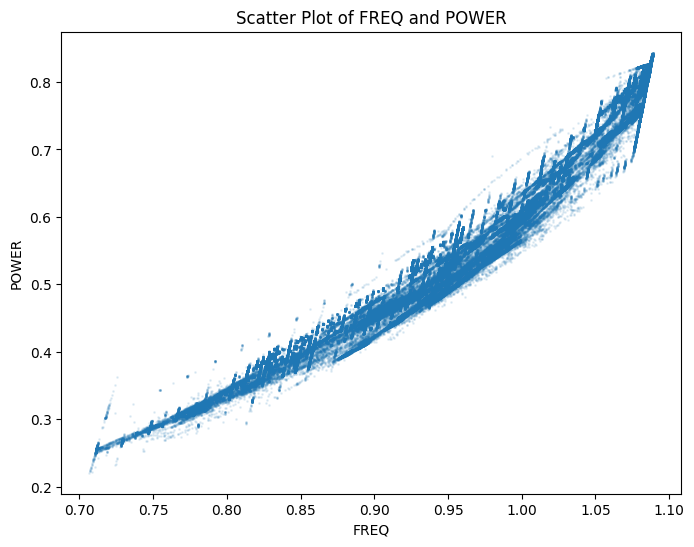

In [3]:
#Scatter Plot to see the relationship between frequency and power
plt.figure(figsize=(8, 6))
plt.scatter(df1['FREQ'], df1['POWER'], s=1, alpha=0.1)
plt.title('Scatter Plot of FREQ and POWER')
plt.xlabel('FREQ')
plt.ylabel('POWER')
plt.show()


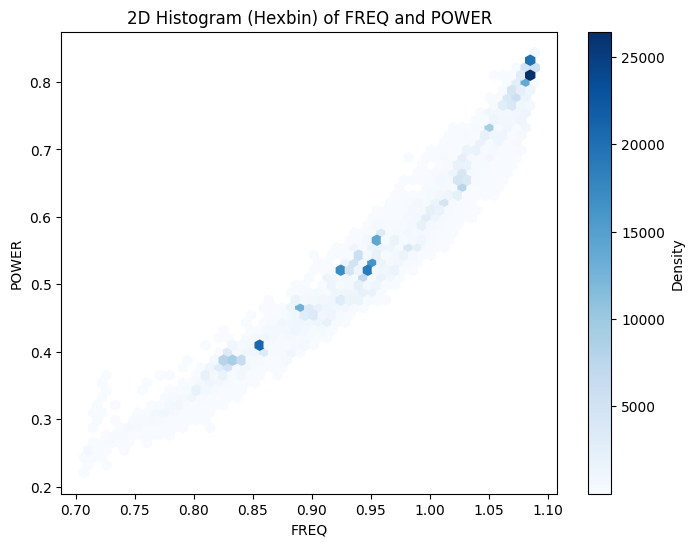

In [4]:
# Hexbin to find point density
plt.figure(figsize=(8, 6))
plt.hexbin(df1['FREQ'], df1['POWER'], gridsize=50, cmap='Blues', mincnt=1)
plt.colorbar(label='Density')
plt.title('2D Histogram (Hexbin) of FREQ and POWER')
plt.xlabel('FREQ')
plt.ylabel('POWER')
plt.show()


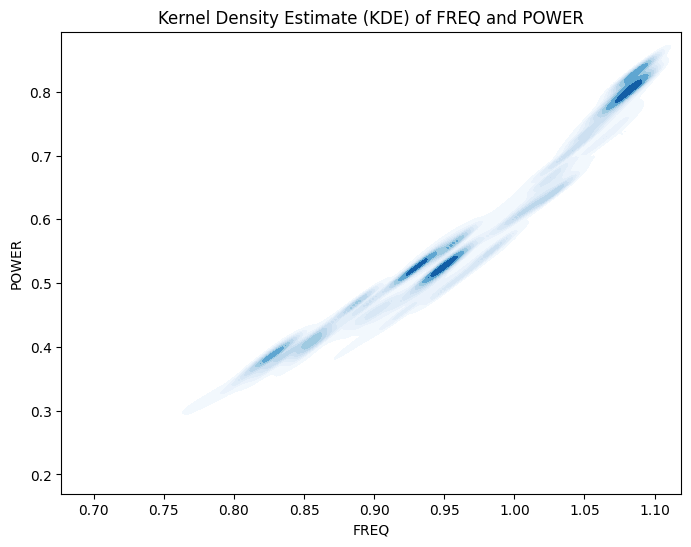

In [5]:
#Kernel Density Estimation (KDE) to find denssity regions
plt.figure(figsize=(8, 6))
sns.kdeplot(x=df1['FREQ'], y=df1['POWER'], fill=True, cmap='Blues', thresh=0.05)
plt.title('Kernel Density Estimate (KDE) of FREQ and POWER')
plt.xlabel('FREQ')
plt.ylabel('POWER')
plt.show()


SELECTION #1 (UNIFORM COVERAGE)

In [6]:
daqta = np.vstack((df1['FREQ'], df1['POWER'])).T

In [7]:
#Define the input space as grid
# Parameters
original_size = len(data)          
downsampled_size = 2500              # Ensure total downsampled size = 2500
grid_size = 20                  # Number of grid divisions (adjustable)

In [8]:
# Normalize data (important for grid-based sampling)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(data)

In [9]:
# Divide the space into a uniform grid
x_min, x_max = X_scaled[:, 0].min(), X_scaled[:, 0].max()
y_min, y_max = X_scaled[:, 1].min(), X_scaled[:, 1].max()

In [10]:
# Create grid coordinates (uniformly spaced grid)
x_grid = np.linspace(x_min, x_max, grid_size)
y_grid = np.linspace(y_min, y_max, grid_size)

# Create grid mesh
grid_x, grid_y = np.meshgrid(x_grid, y_grid)

In [11]:
# Assign each data set to a grid cell
tree = cKDTree(X_scaled)  # Efficient nearest neighbor search
grid_cells = []

In [12]:
# Assign data set to grid cells
for i in range(grid_size - 1):
    for j in range(grid_size - 1):
        # Define the boundaries of each grid cell
        x_min_cell, x_max_cell = x_grid[i], x_grid[i + 1]
        y_min_cell, y_max_cell = y_grid[j], y_grid[j + 1]
        
        # Find points inside the grid cell
        points_in_cell = np.where(
            (X_scaled[:, 0] >= x_min_cell) & (X_scaled[:, 0] < x_max_cell) &
            (X_scaled[:, 1] >= y_min_cell) & (X_scaled[:, 1] < y_max_cell)
        )[0]
        
        grid_cells.append(points_in_cell)


In [13]:
# Select dataset from each grid cell (uniformly)
downsampled_indices = []
points_per_cell = downsampled_size // len(grid_cells)  # datasets to select per grid cell

In [14]:
# Distribute remaining points across cells
remaining_points = downsampled_size - points_per_cell * len(grid_cells)

for cell in grid_cells:
    if len(cell) >= points_per_cell:
        # Randomly select points from the grid cell
        selected_points = np.random.choice(cell, size=points_per_cell, replace=False)
        downsampled_indices.extend(selected_points)


In [15]:
# If there are remaining points to be distributed (due to rounding), add them randomly
if remaining_points > 0:
    all_points = np.concatenate(grid_cells)
    additional_points = np.random.choice(all_points, size=remaining_points, replace=False)
    downsampled_indices.extend(additional_points)

In [ ]:
# Downsampled dataset
downsampled_uniform_data = data[downsampled_indices]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 0 entries
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       0 non-null      float64
 1   1       0 non-null      float64
dtypes: float64(2)
memory usage: 132.0 bytes


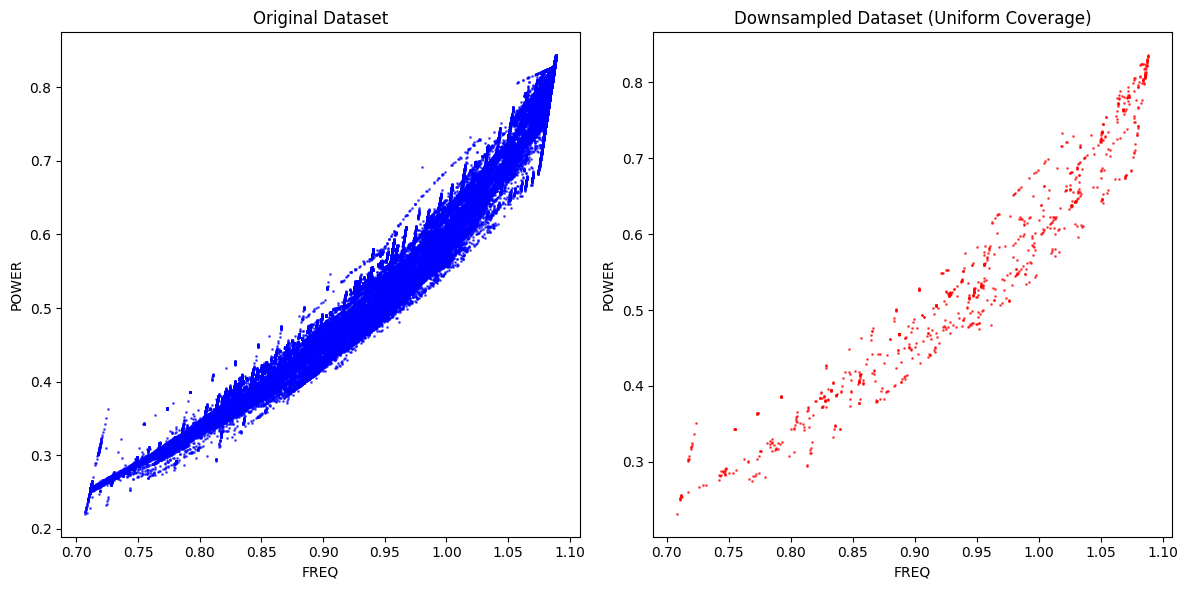

In [17]:
# Visualization
plt.figure(figsize=(12, 6))

# Plot original dataset
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c='blue', s=1, alpha=0.6)
plt.title("Original Dataset")
plt.xlabel("FREQ")
plt.ylabel("POWER")

# Plot downsampled dataset
plt.subplot(1, 2, 2)
plt.scatter(downsampled_uniform_data[:, 0], downsampled_uniform_data[:, 1], c='red', s=1, alpha=0.6)
plt.title("Downsampled Dataset (Uniform Coverage)")
plt.xlabel("FREQ")
plt.ylabel("POWER")

plt.tight_layout()
plt.show()

In [18]:
# Use Nearest Neighbors to calculate distances to nearest neighbors
nbrs = NearestNeighbors(n_neighbors=2).fit(downsampled_uniform_data)
distances, _ = nbrs.kneighbors(downsampled_uniform_data)

# Take the first neighbor distance (ignoring the zero distance to itself)
nearest_neighbor_distances = distances[:, 1]

# Calculate mean and variance of nearest neighbor distances
mean_distance = np.mean(nearest_neighbor_distances)
variance_distance = np.var(nearest_neighbor_distances)

print(f"Mean distance to nearest neighbor: {mean_distance}")
print(f"Variance of nearest neighbor distances: {variance_distance}")

Mean distance to nearest neighbor: 0.0020495348302736554
Variance of nearest neighbor distances: 5.593576523976415e-06


SELECTION #2 (HIGH-DENSITY REGIONS)

KMeans CLUSTERING

In [19]:
#Normalize the Data / NOT NEED
#FREQ_normalized = (df1['FREQ'] - np.min(df1['FREQ']) / np.max(df1['FREQ'] - np.min(df1['FREQ'])))
#POWER_normalized = (df1['POWER'] - np.min(df1['POWER']) / np.max(df1['POWER'] - np.min(df1['POWER'])))

data = np.vstack((df1['FREQ'], df1['POWER'])).T

In [20]:
#Find optimal number of clusters
inertia = []
cluster_range = range(1, 15)  # Testing clusters from 1 to 15

for k in cluster_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(data)
    inertia.append(kmeans.inertia_)

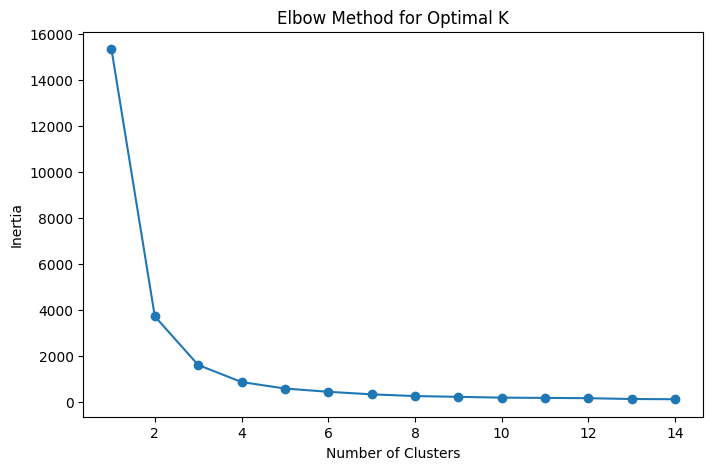

In [21]:
# Plot the inertia values to find the "elbow"
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


In [22]:
n_clusters = 3  # Fixed number of clusters after determining optimal K
random_states = range(1, 100)  # Test 20 different random states
inertia_scores = {}

# Run K-Means for each random state and record inertia
for state in random_states:
    kmeans = KMeans(n_clusters=n_clusters, random_state=state)
    kmeans.fit(data)
    inertia_scores[state] = kmeans.inertia_


In [23]:
# Find the random state with the lowest inertia
best_random_state = min(inertia_scores, key=inertia_scores.get)

# Output the best random state and its inertia
print("Best Random State for K-Means:", best_random_state)
print("Lowest Inertia Achieved:", inertia_scores[best_random_state])

Best Random State for K-Means: 57
Lowest Inertia Achieved: 1598.7339763345406


In [24]:
#KMeans Clustering Based on best parameters
kmeans = KMeans(n_clusters=3, random_state=57)
kmeans.fit(data)

KMeans(n_clusters=3, random_state=57)

In [25]:
# Get the cluster labels and centroids
kmeans_labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [26]:
# Compute density for K-Means (the number of points in each cluster)
kmeans_densities = [int(np.sum(kmeans_labels == i)) for i in range(kmeans.n_clusters)]
print("K-Means Cluster Densities:", kmeans_densities)

K-Means Cluster Densities: [197137, 161345, 141518]


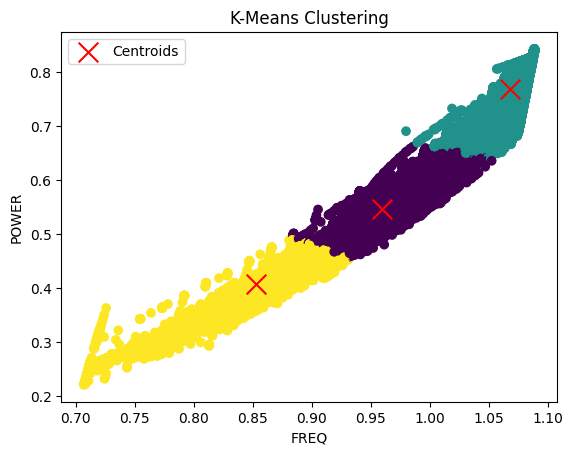

In [27]:
# Plot the data points and the centroids
plt.scatter(df1['FREQ'], df1['POWER'], c=kmeans_labels, cmap='viridis')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=200, label='Centroids')
plt.xlabel('FREQ')
plt.ylabel('POWER')
plt.title('K-Means Clustering')
plt.legend()
plt.show()


GMM CLUSTERING

In [28]:
#Gaussian Mixture Model (GMM)
bic_scores = []
n_components_range = range(1, 15)  # Testing components from 1 to 15

for n in n_components_range:
    gmm = GaussianMixture(n_components=n)
    gmm.fit(data)
    bic_scores.append(gmm.bic(data))

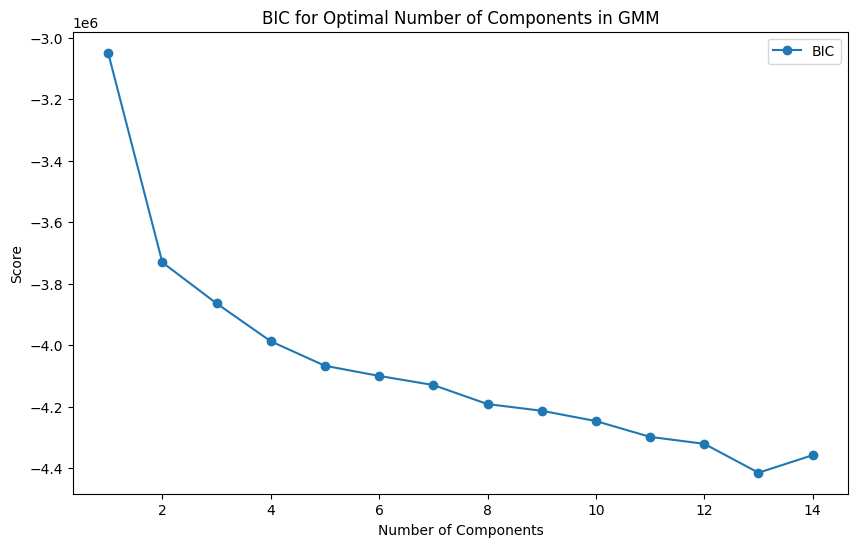

In [29]:
# Plot BIC and AIC Scores
plt.figure(figsize=(10, 6))
plt.plot(n_components_range, bic_scores, marker='o', label='BIC')
plt.xlabel('Number of Components')
plt.ylabel('Score')
plt.legend()
plt.title('BIC for Optimal Number of Components in GMM')
plt.show()

In [30]:
#GMM Clustering Based on best parameters
gmm = GaussianMixture(n_components=3, random_state=57)
gmm.fit(data)

GaussianMixture(n_components=3, random_state=57)

In [31]:
# Get the cluster labels and centroids
gmm_labels = gmm.predict(data)
centroids = gmm.means_

In [32]:
# Compute density for GMM (the number of points in each cluster)
gmm_densities = [int(np.sum(gmm_labels == i)) for i in range(gmm.n_components)]
print("GMM Cluster Densities:", gmm_densities)

GMM Cluster Densities: [268789, 120003, 111208]


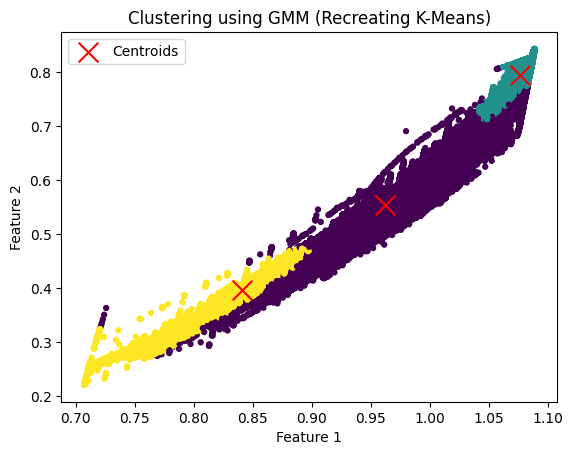

GMM Centroids (means of the Gaussian distributions):
[[0.9622242  0.55314978]
 [1.07687929 0.79508702]
 [0.84124041 0.39727179]]


In [33]:
# 4. Plot the results
plt.scatter(data[:, 0], data[:, 1], c=gmm_labels, cmap='viridis', s=50, marker='.')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=200, marker='x', label='Centroids')
plt.title("Clustering using GMM (Recreating K-Means)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

# Print out the GMM centroids
print("GMM Centroids (means of the Gaussian distributions):")
print(centroids)

KMeans might work better to find the densities for the data

DOWNSAMPLING 

In [34]:
#Original Dataset size
original_size = len(data)

#Downsample Dataset size
downsampled_size = 2500

In [35]:
# Calculate the number of points to sample from each cluster
cluster_counts = Counter(kmeans_labels)   # Count points in each cluster
downsampled_counts = {label: int(count * downsampled_size / original_size) 
                      for label, count in cluster_counts.items()}

total_downsampled = sum(downsampled_counts.values())

In [36]:
#Ensure downsampled dataset size is below 2500
if total_downsampled > downsampled_size:
    difference = total_downsampled - downsampled_size
    # Reduce the sample size from the largest cluster
    largest_cluster = max(downsampled_counts, key=downsampled_counts.get)
    downsampled_counts[largest_cluster] -= difference

In [37]:
# Sample points from each cluster
downsampled_indices = []

for cluster_label, count in downsampled_counts.items():
    # Get indices of all points in this cluster
    cluster_indices = np.where(kmeans_labels == cluster_label)[0]
    
    # Randomly sample the desired number of points for this cluster
    sampled_indices = np.random.choice(cluster_indices, size=count, replace=False)
    
    # Add to the final list of downsampled indices
    downsampled_indices.extend(sampled_indices)

In [38]:
# Create the downsampled dataset
downsampled_density_data = data[downsampled_indices]
downsampled_labels = kmeans_labels[downsampled_indices]  # Ensure consistent labels

In [39]:
print(f"Original size: {original_size}")
print(f"Downsampled size: {len(downsampled_density_data)}")

Original size: 500000
Downsampled size: 2498


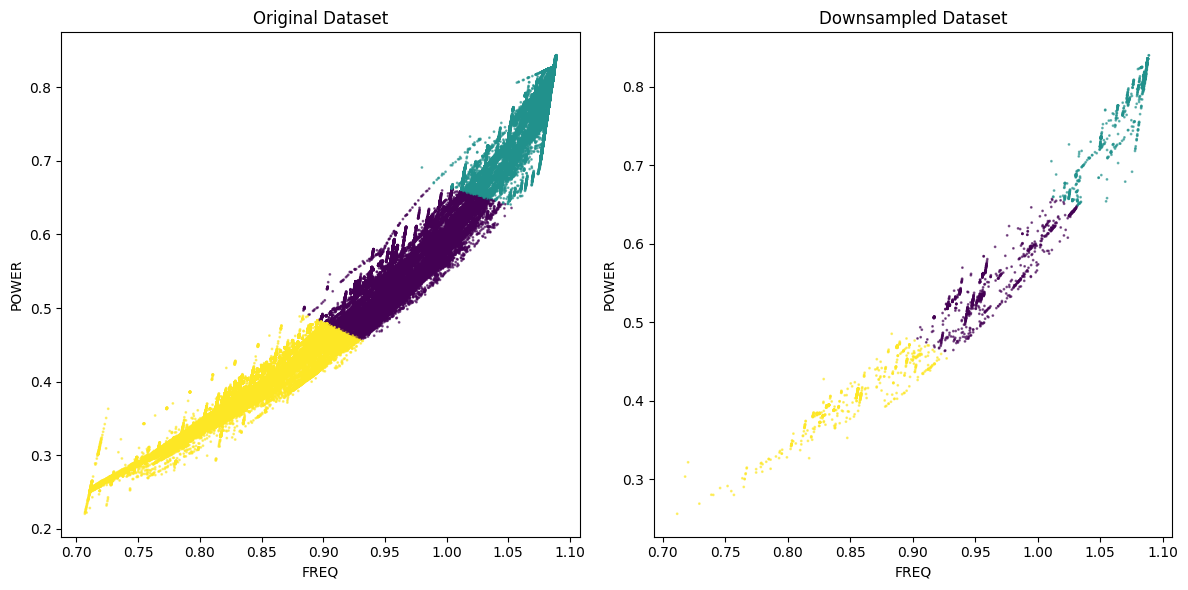

In [41]:
# VISUALIZE DOWNSAMPLED DATA AND COMPARE WITH ORGINAL DATA
# Step 1: Visualization
plt.figure(figsize=(12, 6))

# Plot original dataset
plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], c=kmeans_labels, cmap='viridis', s=1, alpha=0.6)
plt.title("Original Dataset")
plt.xlabel("FREQ")
plt.ylabel("POWER")

# Plot downsampled dataset
plt.subplot(1, 2, 2)
plt.scatter(downsampled_density_data[:, 0], downsampled_density_data[:, 1], c=downsampled_labels, cmap='viridis', s=1, alpha=0.6)
plt.title("Downsampled Dataset")
plt.xlabel("FREQ")
plt.ylabel("POWER")

plt.tight_layout()
plt.show()

In [44]:
# Original cluster density proportions
original_density = np.array([cluster_counts[i] / original_size for i in range(n_clusters)])

# Downsampled cluster density proportions
downsampled_density = np.array([downsampled_counts[i] / downsampled_size for i in range(n_clusters)])

# Calculate Pearson correlation for similarity in distributions
correlation, _ = pearsonr(original_density, downsampled_density)

print("Correlation between original and downsampled cluster densities:", correlation)


Correlation between original and downsampled cluster densities: 0.9999999164348159


COMPARISON SELECTION 1 AND SELECTION 2

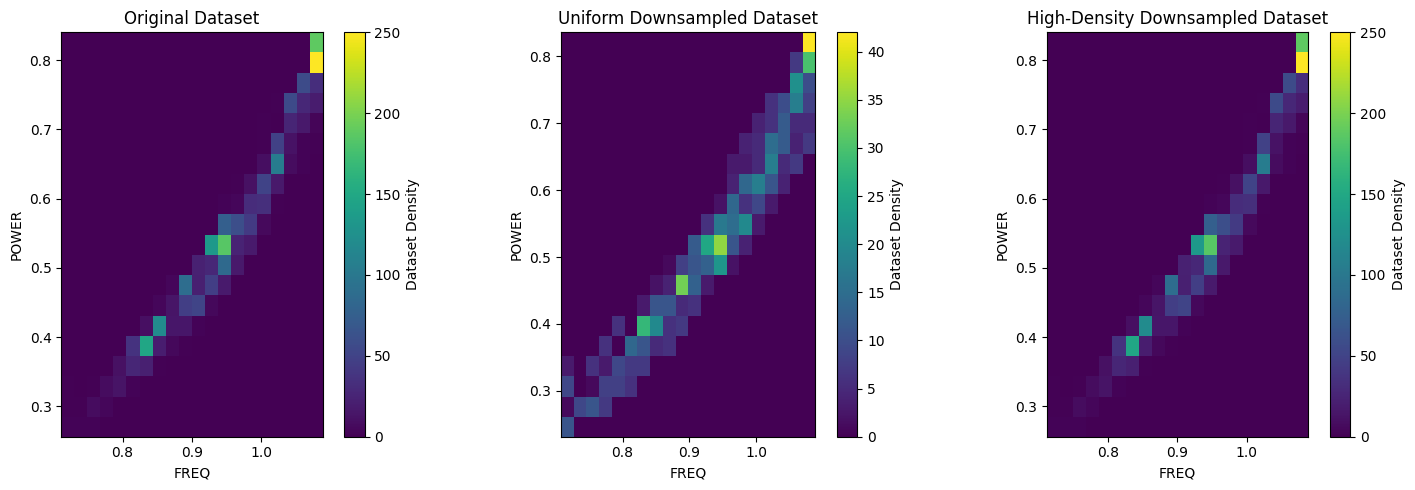

In [46]:
# Create heatmaps for each dataset
datasets = {
    "Original Dataset": data,
    "Uniform Downsampled Dataset": downsampled_uniform_data,
    "High-Density Downsampled Dataset": downsampled_density_data
}

plt.figure(figsize=(15, 5))

for i, (title, data) in enumerate(datasets.items(), 1):
    # Calculate point density in each grid cell
    density, x_edges, y_edges = np.histogram2d(data[:, 0], data[:, 1], bins=grid_size)

    # Plot heatmap of point density
    plt.subplot(1, 3, i)
    plt.imshow(density.T, origin='lower', cmap='viridis', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
    plt.colorbar(label='Dataset Density')
    plt.xlabel("FREQ")
    plt.ylabel("POWER")
    plt.title(title)

plt.tight_layout()
plt.show()